In [7]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as plticker
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator, NullLocator, ScalarFormatter, AutoLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import gaussian_kde
from scipy.stats import kde
from astropy.modeling import models, fitting

import numpy as np

from time import time
# import pyemma.utils_functions as utils
import sys
import json
%matplotlib inline

In [2]:
import argparse
parser = argparse.ArgumentParser(prog = 'Run Model')
parser.add_argument('--dimensionality', type=int, choices=[2, 3], default=3)
parser.add_argument('--removed_average', type=int, choices=[0, 1], default=1)
parser.add_argument('--Zmax', type=int, default=30)
parser.add_argument('--data_location', type=str, default="../data/")
parser.add_argument('--saving_location', type=str, default="../models/")
parser.add_argument('--logs_location', type=str, default="../logs/")
parser.add_argument('--model', type=str, default="RNN.SummarySpace3D")
parser.add_argument('--HyperparameterIndex', type=int, choices=range(576), default=0)
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--gpus', type=int, default=1)
parser.add_argument('--multi_gpu_correction', type=int, choices=[0, 1, 2], default=0, help="0-none, 1-batch_size, 2-learning_rate")
parser.add_argument('--file_prefix', type=str, default="")

inputs = parser.parse_args(['--model', 'CNN.basic2D', '--dimensionality', '2', '--HyperparameterIndex', '237'])
inputs.removed_average = bool(inputs.removed_average)
inputs.model = inputs.model.split('.')
print("INPUTS:", inputs)

INPUTS: Namespace(HyperparameterIndex=237, Zmax=30, data_location='../data/', dimensionality=2, epochs=200, file_prefix='', gpus=1, logs_location='../logs/', model=['CNN', 'basic2D'], multi_gpu_correction=0, removed_average=True, saving_location='../models/')


In [3]:
import tensorflow as tf
# #setting up GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1. #setting the percentage of GPU usage
config.gpu_options.visible_device_list = "0" #for picking only some devices
config.gpu_options.allow_growth = True
# config.log_device_placement=True
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
tf.compat.v1.enable_eager_execution(config=config)

from tensorflow import keras
keras.backend.set_image_data_format('channels_last')

import copy
import itertools
import sys
import importlib
import numpy as np

import src.py21cnn.utilities as utilities
ModelClassObject = getattr(importlib.import_module(f'src.py21cnn.architectures.{inputs.model[0]}'), inputs.model[1])

def leakyrelu(x):
    return keras.activations.relu(x, alpha=0.1)

HyP = {}
HyP["Loss"] = [[None, "mse"]]
HyP["Epochs"] = [inputs.epochs]
HyP["BatchSize"] = [20, 100]
HyP["LearningRate"] = [0.01, 0.001, 0.0001]
HyP["Dropout"] = [0.2, 0.5]
HyP["ReducingLR"] = [True]
HyP["BatchNormalization"] = [True, False]
HyP["Optimizer"] = [
                    [keras.optimizers.RMSprop, "RMSprop", {}],
                    [keras.optimizers.SGD, "SGD", {}],
                    [keras.optimizers.SGD, "Momentum", {"momentum":0.9, "nesterov":True}],
                    # [keras.optimizers.Adadelta, "Adadelta", {}],
                    # [keras.optimizers.Adagrad, "Adagrad", {}],
                    [keras.optimizers.Adam, "Adam", {}],
                    # [keras.optimizers.Adam, "Adam", {"amsgrad":True}],
                    [keras.optimizers.Adamax, "Adamax", {}],
                    [keras.optimizers.Nadam, "Nadam", {}],
                    ]
HyP["ActivationFunction"] = [
                            ["relu", {"activation": keras.activations.relu, "kernel_initializer": keras.initializers.he_uniform()}],
                            # [keras.layers.LeakyReLU(alpha=0.1), "leakyrelu"],
                            ["leakyrelu", {"activation": leakyrelu, "kernel_initializer": keras.initializers.he_uniform()}],
                            ["elu", {"activation": keras.activations.elu, "kernel_initializer": keras.initializers.he_uniform()}],
                            ["selu", {"activation": keras.activations.selu, "kernel_initializer": keras.initializers.lecun_normal()}],
                            # [keras.activations.exponential, "exponential"],
                            # [keras.activations.tanh, "tanh"],
                            ]


HyP_list = list(itertools.product(*HyP.values()))
HP_dict = dict(zip(HyP.keys(), HyP_list[inputs.HyperparameterIndex]))
HP = utilities.AuxiliaryHyperparameters(**HP_dict)
#creating HP dict for TensorBoard with only HP that are changing and only human-readable information
HP_TensorBoard = {}
HP_TensorBoard["Model"] = f"{inputs.model[0]}_{inputs.model[1]}"
HP_TensorBoard["LearningRate"] = HP_dict["LearningRate"]
HP_TensorBoard["Dropout"] = HP_dict["Dropout"]
HP_TensorBoard["BatchSize"] = HP_dict["BatchSize"]
HP_TensorBoard["BatchNormalization"] = HP_dict["BatchNormalization"]
HP_TensorBoard["Optimizer"] = HP_dict["Optimizer"][1]
HP_TensorBoard["ActivationFunction"] = HP_dict["ActivationFunction"][0]

Data = utilities.Data(filepath=inputs.data_location, 
                      dimensionality=inputs.dimensionality, 
                      removed_average=inputs.removed_average, 
                      Zmax=inputs.Zmax)

/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it

/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21CNN_GPU_NEW/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future

In [4]:
def R2(y_true, y_pred):
        SS_res = keras.backend.sum(keras.backend.square(y_true-y_pred)) 
        SS_tot = keras.backend.sum(keras.backend.square(y_true - keras.backend.mean(y_true, axis=0)))
        return (1 - SS_res/(SS_tot + keras.backend.epsilon()))

In [5]:
y_true = np.load(f"{Data.filepath}Y_test_0.10_{Data.hash()}.npy")

filepath = f"{inputs.saving_location}{inputs.file_prefix}{inputs.model[0]}_{inputs.model[1]}_{HP.hash()}_{Data.hash()}"
custom_obj = {}
custom_obj["R2"] = R2
# custom_obj["TimeHistory"] = TimeHistory
#if activation is leakyrelu add to custom_obj
if HP.ActivationFunction[0] == "leakyrelu":
    custom_obj[HP.ActivationFunction[0]] = HP.ActivationFunction[1]["activation"]
model = keras.models.load_model(f"{filepath}_best.hdf5", custom_objects=custom_obj)
model.summary()

X_test = np.load(f"{Data.filepath}X_test_0.10_{Data.hash()}.npy")
X_test = X_test[..., np.newaxis]

y_pred = model.predict(X_test)

Model: "CNN_basic2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 526, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 519, 32)       2080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 129, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 129, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 129, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 126, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 63, 128)        

In [8]:
print(y_true.shape)
print(y_pred.shape)

(40000, 4)
(40000, 4)


In [9]:
with open(f"{inputs.data_location}databaseParams_min_max.txt") as f:
    y_range = json.load(f)
y_range["LatexNames"] = [r'$\rm{\zeta}$', 
                         r'$\rm{log_{10}(T_{vir})}$', 
                         r'$\rm{log_{10}(L_X/SFR) }$', 
                         r'$\rm{E_0}$' ]
y_range["LatexUnits"] = ['', 
                         r'$\rm{ [K] }$', 
                         r'$\rm{ [erg\ s^{-1}\ M^{-1}_{\odot}\ yr] }$', 
                         r'$\rm{ [keV] }$' ]
    
print(y_range)

{'parameters': ['ZETA', 'TVIR_MIN', 'L_X', 'NU_X_THRESH'], 'min': [10.023063659667969, 4.000161170959473, 38.00041961669922, 100.13026428222656], 'max': [249.9544677734375, 5.998933792114258, 41.99989700317383, 1499.37109375], 'LatexNames': ['$\\rm{\\zeta}$', '$\\rm{log_{10}(T_{vir})}$', '$\\rm{log_{10}(L_X/SFR) }$', '$\\rm{E_0}$'], 'LatexUnits': ['', '$\\rm{ [K] }$', '$\\rm{ [erg\\ s^{-1}\\ M^{-1}_{\\odot}\\ yr] }$', '$\\rm{ [keV] }$']}


In [10]:
def rescale(y_true, y_pred, y_range, filepath, pTVT = [0.8, 0.1, 0.1]):
    Y = {}
    for p, key in zip(pTVT, ['train', 'val', 'test']):
        Y[key] = np.load(f"{filepath}Y_{key}_{p:.2f}_{Data.hash()}.npy")
    y_tot = np.concatenate((Y['train'], Y['val'], Y['test']), axis=0)
    print(y_tot.shape)
    minimum, maximum = np.amin(y_tot, axis=0), np.amax(y_tot, axis = 0)
    print(minimum, maximum)
    y_true = (y_true - minimum)/(maximum - minimum)
    y_pred = (y_pred - minimum)/(maximum - minimum)
    print('should be 0-1')
    print(np.amin(y_true, axis=0), np.amax(y_true, axis=0))
    print(np.amin(y_pred, axis=0), np.amax(y_pred, axis=0))
    y_range['min'] = np.array(y_range['min'])
    y_range['max'] = np.array(y_range['max'])
    print('should be in y_range')
    y_true = y_true * (y_range['max'] - y_range['min']) + y_range['min']
    y_pred = y_pred * (y_range['max'] - y_range['min']) + y_range['min']
    print(np.amin(y_true, axis=0), np.amax(y_true, axis=0))
    print(np.amin(y_pred, axis=0), np.amax(y_pred, axis=0))
    return y_true, y_pred

In [11]:
y_true, y_pred = rescale(y_true, y_pred, y_range, inputs.data_location)

(400000, 4)
[-1.7532961 -1.7414337 -1.7245299 -1.731023 ] [1.720982  1.7585793 1.7312908 1.7340564]
should be 0-1
[0.         0.00010286 0.         0.        ] [1. 1. 1. 1.]
[-0.02699548 -0.00699364 -0.02992705 -0.01991933] [1.024293  1.0074186 1.0111947 1.028854 ]
should be in y_range
[ 10.02306366   4.00036677  38.00041962 100.13026428] [ 249.95446777    5.99893379   41.999897   1499.37109375]
[ 3.54599933  3.98618247 37.88072705 72.25832409] [ 255.78310838    6.01376195   42.04466998 1539.74480612]


In [41]:
colour_map = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.25, 'yellow'),(0.5, 'orange'),(0.75, 'red'),(1, 'black')])
plt.register_cmap(cmap=colour_map)

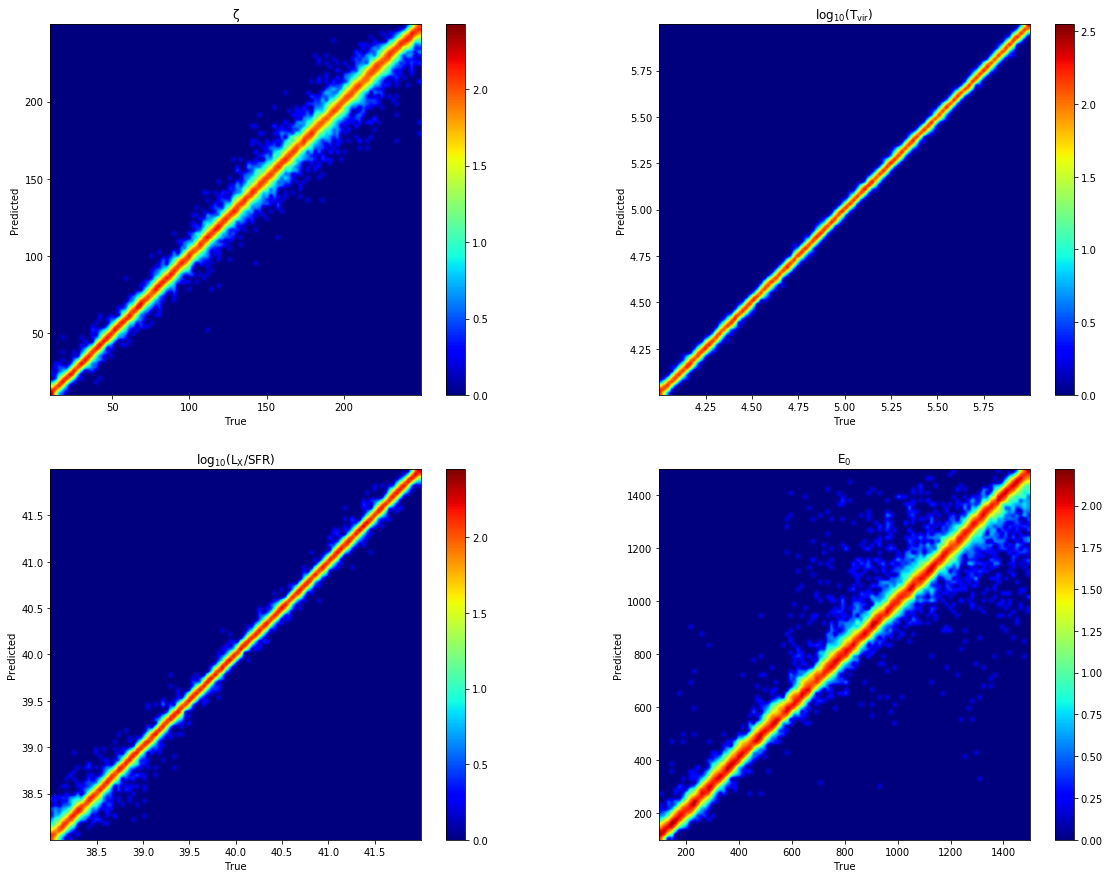

In [69]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))
nbins = 100
for i in range(4):
#     ax[i//2, i%2].scatter(y_true[:, i], y_pred[:, i])
    x = y_true[:, i]
    y = y_pred[:, i]
    minmax = [y_range['min'][i], y_range['max'][i]]
    hist, xedges, yedges = np.histogram2d(x, y, range = [minmax, minmax], bins=nbins)
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    hist = np.log10(1 + hist.T)
#     k = kde.gaussian_kde([x, y])
#     xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

#     zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    X, Y = np.meshgrid(xedges, yedges)
#     ax[i//2, i%2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.get_cmap('inferno'))
#     ax[i//2, i%2].pcolormesh(X, Y, hist, shading='gouraud', cmap=plt.get_cmap('inferno'))
    interp = 'gaussian'
    im = ax[i//2, i%2].imshow(hist, origin='low', interpolation=interp, cmap=plt.cm.jet, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#     ax[i//2, i%2].contour(xi, yi, zi.reshape(xi.shape) )
#     ax[i//2, i%2].plot([[minmax[0], minmax[0]], [minmax[1], minmax[1]]], 'k--', lw=1)
    ax[i//2, i%2].set_xlabel("True")
    ax[i//2, i%2].set_ylabel("Predicted")
    ax[i//2, i%2].set_title(y_range["LatexNames"][i])
    fig.colorbar(im, ax=ax[i//2, i%2])
plt.show()

In [52]:
def R2( out_model, Param):
    return 1 - ( (out_model - Param)**2).sum(axis=0) / ((out_model - out_model.mean(axis=0) )**2).sum(axis=0) 

In [53]:
r2_score = np.zeros(4)
for i in range(4):
    r2_score = R2(y_pred[:, i], y_true[:, i])
    print(r2_score)

0.9964878005270932
0.9996354508131451
0.9988069117060884
0.9851447480775275


(400000, 4)
[-1.7532961 -1.7414337 -1.7245299 -1.731023 ] [1.720982  1.7585793 1.7312908 1.7340564]
should be 0-1
[0.         0.00010286 0.         0.        ] [1. 1. 1. 1.]
[-0.02699548 -0.00699364 -0.02992705 -0.01991933] [1.024293  1.0074186 1.0111947 1.028854 ]
should be in y_range
[ 10.02306366   4.00036677  38.00041962 100.13026428] [ 249.95446777    5.99893379   41.999897   1499.37109375]
[ 3.54599933  3.98618247 37.88072705 72.25832409] [ 255.78310838    6.01376195   42.04466998 1539.74480612]


In [66]:
def plot_CNN_out( out, Y, Ybackup, paramNum, Nbin=20, Brad_pt=None, color='b'):
    VALUE_TRUE = Y
    VALUE_PRED = out
    RESIDUAL = (VALUE_PRED - VALUE_TRUE)    
    
    pmin = VALUE_TRUE.min()
    pmax = VALUE_TRUE.max()
    d    = pmax - pmin 
    
    print( 'number of points: ', RESIDUAL.size )
    bin_VALUE_TRUE = np.linspace( pmin, pmax, Nbin )

    h2, yh2, xh2 = np.histogram2d( VALUE_PRED, VALUE_TRUE, bins=[bin_VALUE_TRUE,bin_VALUE_TRUE] )
    h1, xh1 = np.histogram( VALUE_TRUE, bins=bin_VALUE_TRUE )
    h_weight, xh_weight = np.histogram( VALUE_TRUE, bins=bin_VALUE_TRUE, weights=RESIDUAL )
    h_id = np.digitize( VALUE_TRUE, xh1 )
    std = np.zeros(Nbin-1)
    mean = np.zeros(Nbin-1)
    median = np.zeros(Nbin-1)
    for i in range(Nbin-1):
        id_ = np.where( h_id==i+1 )[0]
        mean[i] = RESIDUAL[id_].sum() / id_.size
        median[i] = np.median( RESIDUAL[id_] )
        std[i] =  np.sqrt( (( RESIDUAL[id_] - mean[i] )**2).sum() / (id_.size-1) )
    eps_mean = mean
    eps_std  = std
    
    ######################################
    ######################################
    ### error on the prediction
    h3, xh3 = np.histogram( VALUE_PRED, bins=bin_VALUE_TRUE )
    h_weight, xh_weight = np.histogram( VALUE_PRED, bins=bin_VALUE_TRUE, weights=RESIDUAL )
    h_id = np.digitize( VALUE_PRED, bin_VALUE_TRUE )
    std_2 = np.zeros(Nbin-1)
    mean_2 = np.zeros(Nbin-1)
    median_2 = np.zeros(Nbin-1)
    for i in range(Nbin-1):
        id_ = np.where( h_id==i+1 )[0]
        mean_2[i] = RESIDUAL[id_].sum() / id_.size
        median_2[i] = np.median( RESIDUAL[id_] )
        std_2[i] =  np.sqrt( (( RESIDUAL[id_] - mean_2[i] )**2).sum() / (id_.size-1) )
    u_mean = mean_2
    u_std  = std_2
    paramName = Ybackup["LatexNames"]
    paramUnit = Ybackup["LatexUnits"]
    ######################################
    ######################################
    RAND_TRUE = np.random.rand( 4000 )*d+pmin ### 
    RAND_PRED = np.random.rand( 4000 )*d+pmin ### 
    RAND_RESIDUAL = RAND_PRED - RAND_TRUE
    
    h4, xh4 = np.histogram( RAND_TRUE, bins=bin_VALUE_TRUE )
    h_weight, xh_weight = np.histogram( RAND_TRUE, bins=bin_VALUE_TRUE, weights=RAND_RESIDUAL )
    h_id = np.digitize( RAND_TRUE, bin_VALUE_TRUE )
    std_3 = np.zeros(Nbin-1)
    mean_3 = np.zeros(Nbin-1)
    median_3 = np.zeros(Nbin-1)
    for i in range(Nbin-1):
        id_ = np.where( h_id==i+1 )[0]
        mean_3[i] = RAND_RESIDUAL[id_].sum() / id_.size
        median_3[i] = np.median( RAND_RESIDUAL[id_] )
        std_3[i] =  np.sqrt( (( RAND_RESIDUAL[id_] - mean_3[i] )**2).sum() / (id_.size-1) )
    ######################################
    ######################################
    fig = plt.figure(  )
    ######################################
    ######################################
    ### TRUE-PREDICTED plot
    ######################################
    ax1 = plt.subplot( 111 )
#     plt.plot( VALUE_TRUE, VALUE_PRED, 'k.', alpha=0.15)
    im = plt.imshow( np.log10(h2 +1), interpolation='gaussian', origin='lower', 
                     extent=[bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1],bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]],
                     cmap= cm.hot_r )#cm.Greys) 

#     data = np.vstack( [VALUE_TRUE, VALUE_PRED] )
#     kde = gaussian_kde(data)
#     X_grid, Y_grid = np.meshgrid( bin_VALUE_TRUE, bin_VALUE_TRUE )
#     Z = kde.evaluate( np.vstack( [X_grid.ravel(), Y_grid.ravel()] ) )
#     im = plt.imshow( (Z.reshape(X_grid.shape)), interpolation='nearest', origin='lower', 
#                      extent=[bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1],bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]],
#                      cmap=cm.Greys) 
    
    plt.plot( [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]], [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]], 'k:', alpha=0.5 ) ### diagonal
    plt.xlim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )
    plt.ylim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )
    ax1.tick_params( axis='x', which='both', bottom='on', top='on', labelbottom='off' )
    ax1.tick_params( axis='y', which='both', bottom='on', top='on', labelbottom='off' )
    ax1.set_xticklabels([])
    ax1.xaxis.set_major_locator( NullLocator() )
    ax1.set_yticklabels([])
    ax1.yaxis.set_major_locator( NullLocator() )
    
    
    plt.legend(loc='best', fontsize=10)

#     ax1.plot( Brad_pt[0,0], Brad_pt[0,1], '^c', label='Faint' )
#     ax1.plot( Brad_pt[1,0], Brad_pt[1,1], 'vc', label='Bright' )
    
    
#     ax1.errorbar( Brad_pt[0,0], Brad_pt[0,1], xerr=[Brad_pt[0,2:]], ecolor='c', fmt='.', color='c', ms=0, errorevery=2 )
#     ax1.errorbar( Brad_pt[1,0], Brad_pt[1,1], xerr=[Brad_pt[1,2:]], ecolor='c', fmt='.', color='c', ms=0, errorevery=2 )
    
#     ax1.set_aspect( (bin_VALUE_TRUE[-1]-bin_VALUE_TRUE[0]) / (bin_VALUE_TRUE[-1]-bin_VALUE_TRUE[0]) )
    
    #plt.ylabel( '%s : Predicted'%paramName[paramNum], fontsize=10 )
    ######################################
    ######################################
    divider = make_axes_locatable(ax1)
    #ax2 = divider.append_axes('bottom', size='50%', pad=0.08)
    ax2 = divider.append_axes('bottom', size='50%', pad=0.25)
    cax = divider.append_axes('right' , size='5%', pad=0.08)
    cb = plt.colorbar( im, ax=ax1, cax=cax )
    cb.set_label( r'$\rm{ log_{10}( Number+1 ) }$', fontsize=10 ) 
    ax3 = divider.append_axes('left', size='50%', pad=0.25)
    ######################################
    ######################################
    ### MEAN-MEDIANE plot
    #ax2.errorbar( utils.zcen(xh1), mean*100, yerr=std*100, ecolor='b', fmt='.', color='b', ms=0, errorevery=2 )
    #ax2.step( xh1, np.append( mean[0], mean )*100, where='pre', lw=2, color='b', label='mean' )
    
    #ax2.fill_between( utils.zcen(bin_VALUE_TRUE), mean_3+std_3, mean_3-std_3, color='k', alpha=0.3 )
                
#     ax2.errorbar( utils.zcen(bin_VALUE_TRUE), mean, yerr=std, ecolor='royalblue', fmt='.', color='royalblue', ms=0, errorevery=2 )
    ax2.step( bin_VALUE_TRUE, np.append( mean[0], mean ), where='pre', lw=2, color='royalblue' )#, label='mean' )
    
    ax2.plot( [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]], [0,0], 'k-' )
    ax2.set_xlim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )
    
    #ylim = ax2.get_ylim()
    #Ntick = np.diff( ylim ) / 4
    #ax2.yaxis.set_major_locator( plticker.MultipleLocator(base=Ntick) )
    
    #[l.set_rotation(45) for l in ax2.get_xticklabels()]
    ax2.xaxis.set_major_locator( MaxNLocator( 5, prune='lower' ) )
    
    [l.set_rotation(45) for l in ax2.get_yticklabels()]
    ax2.yaxis.set_major_locator( MaxNLocator( 5, prune='upper' ) )
    #ax2.yaxis.set_major_locator( AutoLocator() )
        
    #ax2.legend(loc='best')
    ax2.tick_params( axis='x', which='both', bottom='on', top='on', labelbottom='on' )
    ax2.set_xlabel( '%s %s, True'%(paramName[paramNum], paramUnit[paramNum]), fontsize=10 )
    ax2.set_ylabel( r'$ \rm{ \epsilon } $', fontsize=10 )
    
    ######################################
    ######################################          
    ax3.plot( [0,0], [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]] , 'k-' )
    
#     ax3.errorbar( mean_2, utils.zcen(bin_VALUE_TRUE), xerr=std_2, ecolor='royalblue', fmt='.', color='royalblue', ms=0, errorevery=2 )
    
    #plt.barh( bin_VALUE_TRUE[:-1], mean_2, height=np.diff(bin_VALUE_TRUE)[0], 
    #          align='edge', color='w', edgecolor='b', lw=2 )
    
    plt.plot(  np.append( mean_2, mean_2[-1] ), bin_VALUE_TRUE, color='royalblue', lw=2, drawstyle='steps-pre' )
    
    ax3.set_ylim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )
    ax3.set_xlim( ax3.get_xlim()[::-1] )
    
    [l.set_rotation(45) for l in ax3.get_xticklabels()]  
    ax3.xaxis.set_major_locator( MaxNLocator( 6, prune='lower', symmetric=True ) )
     
    fig.canvas.draw()    
    labels = [ item.get_text() for item in ax3.get_xticklabels() ]
    #print(labels)
    labels[0] = ''
    ax3.set_xticklabels( labels )
    
#     ax3.plot( Brad_pt[0,1]-Brad_pt[0,0], Brad_pt[0,1], '^c' )
#     ax3.plot( Brad_pt[1,1]-Brad_pt[1,0], Brad_pt[1,1], 'vc' )
    
#     ax3.errorbar( Brad_pt[0,1]-Brad_pt[0,0], Brad_pt[0,1], xerr=[Brad_pt[0,2:]], ecolor='c', fmt='.', color='c', ms=0, errorevery=2 )
#     ax3.errorbar( Brad_pt[1,1]-Brad_pt[1,0], Brad_pt[1,1], xerr=[Brad_pt[1,2:]], ecolor='c', fmt='.', color='c', ms=0, errorevery=2 )
    
    ax3.set_ylabel( '%s, Predicted'%paramName[paramNum], fontsize=10 )
    ax3.set_xlabel( r'$ \rm{ u } $', fontsize=10 )
    ######################################
    ######################################
    fig.tight_layout()
    
    return fig, bin_VALUE_TRUE, eps_mean,eps_std, u_mean, u_std

def plot_result( y_pred, param_num, Y, Ybackup, name, Nbin=100, save=False, save_name='',
                 Brad_pt=None):
    
    paramName = Ybackup["parameters"]
    ### GET THE PREDICTED VALUES
    out_model = y_pred
    out_shape = out_model.shape
    
    bin_true = np.zeros([len(param_num),Nbin])
    eps_mean = np.zeros([len(param_num),Nbin-1])
    eps_std  = np.zeros([len(param_num),Nbin-1])
    u_mean   = np.zeros([len(param_num),Nbin-1])
    u_std    = np.zeros([len(param_num),Nbin-1])
    for num in param_num:
        print( 'R2 %s: '%(paramName[num]),  R2( out_model[:,num], Y[:,num] ) )
        print( 'plots/%s'%paramName[num]+name+'.pdf' )

        fT, bin_true[num,:], eps_mean[num,:], eps_std[num,:], u_mean[num,:], u_std[num,:] = plot_CNN_out( out_model[:,num],  
                                                                                                          Y[:, num], 
                                                                                                         Ybackup, 
                                                                                                         num, 
                                                                                                         Nbin,
                                                                                                         Brad_pt = None)
#         if save:
#             print( 'plots/%s'%paramName[num]+name+save_name )
#             utils.saveFig( fT, 'plots/%s'%paramName[num]+name+save_name+'.pdf' )
#             utils.saveFig( fT, 'plots/%s'%paramName[num]+name+save_name )
                
                
    return bin_true, eps_mean, eps_std, u_mean, u_std

No handles with labels found to put in legend.


R2 ZETA:  0.9964878005270932
plots/ZETA.pdf
number of points:  40000


No handles with labels found to put in legend.


R2 TVIR_MIN:  0.9996354508131451
plots/TVIR_MIN.pdf
number of points:  40000


No handles with labels found to put in legend.


R2 L_X:  0.9988069117060884
plots/L_X.pdf
number of points:  40000


No handles with labels found to put in legend.


R2 NU_X_THRESH:  0.9851447480775275
plots/NU_X_THRESH.pdf
number of points:  40000


<Figure size 1440x1440 with 0 Axes>

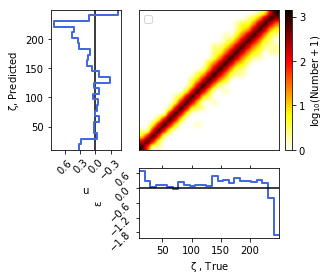

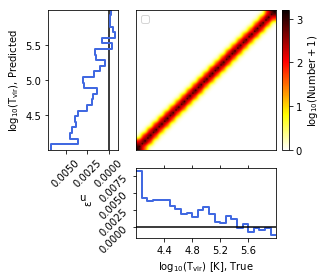

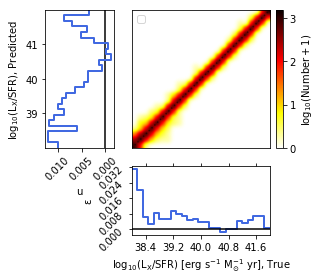

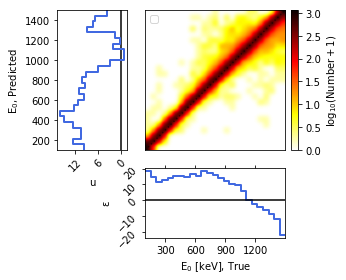

In [67]:
plt.figure(figsize=(20, 20))
bin_true, eps_mean, eps_std, u_mean, u_std = plot_result(y_pred, 
                                                         [0,1,2,3], 
                                                          y_true, y_range, 
                                                          name='',
                                                          Nbin=25+1, 
                                                          save=False, 
                                                          Brad_pt=None, 
                                                            )